# Imports

In [509]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import scipy.stats as stats
from yellowbrick.regressor import ResidualsPlot

# visualization
%matplotlib inline
import seaborn as sns

# pd.read_csv

In [510]:
df = pd.read_csv('data/df_final.csv')

/Users/briantam/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (10,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120832 entries, 0 to 120831
Data columns (total 44 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          120832 non-null  int64  
 1   Unnamed: 0.1        120832 non-null  int64  
 2   rank                19535 non-null   float64
 3   game_id             120832 non-null  object 
 4   game_num            120832 non-null  int64  
 5   names               120832 non-null  object 
 6   year                111384 non-null  float64
 7   geek_rating         26561 non-null   float64
 8   avg_rating          91376 non-null   float64
 9   num_votes           91376 non-null   float64
 10  price_of_boardgame  7004 non-null    object 
 11  minplayers          120830 non-null  float64
 12  maxplayers          120830 non-null  float64
 13  avg_time            120830 non-null  float64
 14  age                 120830 non-null  float64
 15  honor               120832 non-nul

# Clean `price` column and replace strings with floats

In [512]:
df['price_of_boardgame'][1]

'79.99'

In [513]:
list_price_float = []
for i in df['price_of_boardgame']:
    try:
        list_price_float.append(float(i))
    except:
        list_price_float.append(i)
df['price_cleaned'] = list_price_float

In [514]:
df['price_cleaned'][[isinstance(i, str) for i in list_price_float]].unique()

array(['(unavailable)', 'To low to display', '3,000.00', '1,238.99'],
      dtype=object)

In [515]:
df[df['price_cleaned']=='3,000.00']

,Unnamed: 0,Unnamed: 0.1,rank,game_id,game_num,names,year,geek_rating,avg_rating,num_votes,...,prime,title,defaultprice,newprice,listprice,url,sponsorurl,body,ggs,price_cleaned
5215,5215,5215,5216.0,/boardgame/12488/wars-trading-card-game,12488,WARS Trading Card Game,2004.0,5.665,6.74,259.0,...,False,"Get WARS Trading Card Game on Amazon.com $3,00...","$3,000.00","$3,000.00",NaN,https://www.amazon.com/dp/B000QV2G5U?tag=itemt...,https://www.amazon.com/dp/B000QV2G5U?tag=itemt...,NaN,NaN,"3,000.00"


## Replace 'unavaliable' and similar with nan's

In [516]:
df['price_cleaned'] = df['price_cleaned'].replace('(unavailable)', np.nan).replace('To low to display', np.nan).replace('3,000.00', np.nan).replace('1,238.99', np.nan)

In [517]:
df['num_of_awards']=[len(i) for i in df['honor']]


In [518]:
df[df['price_cleaned'] > 150].shape

(274, 44)

In [519]:
# Games above $150 are ridiculous & inflated due to being 'antique' or 'niche'
mask = df.price_cleaned > 150
column_name = 'price_cleaned'
df.loc[mask, column_name] = np.nan

In [520]:
# We don't want to look at games who have no owners caus the log transform goes to infinity
mask = df.owned == 0
column_name = 'owned'
df.loc[mask, column_name] = 0

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120832 entries, 0 to 120831
Data columns (total 44 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          120832 non-null  int64  
 1   Unnamed: 0.1        120832 non-null  int64  
 2   rank                19535 non-null   float64
 3   game_id             120832 non-null  object 
 4   game_num            120832 non-null  int64  
 5   names               120832 non-null  object 
 6   year                111384 non-null  float64
 7   geek_rating         26561 non-null   float64
 8   avg_rating          91376 non-null   float64
 9   num_votes           91376 non-null   float64
 10  price_of_boardgame  7004 non-null    object 
 11  minplayers          120830 non-null  float64
 12  maxplayers          120830 non-null  float64
 13  avg_time            120830 non-null  float64
 14  age                 120830 non-null  float64
 15  honor               120832 non-nul

In [522]:
df_small = df.loc[:,[
             'rank',
             'game_id',
             'game_num',
             'names',
             'year',
             'geek_rating',
             'avg_rating',
             'num_votes',
             'price_of_boardgame',
             'minplayers',
             'maxplayers',
             'avg_time',
             'age',
             'honor',
             'mechanics',
             'mech_list',
             'category',
             'categ_list',
             'owned',
             'trading',
             'wanting',
             'wishing',
             'numcomments',
             'numweights',
             'averageweight',
             'kickstarted',
             'family_subgroup',
             'sub_domain',
             'podcasts',
             'sponsorname',
             'supersaver',
             'prime',
             'title',
             'defaultprice',
             'newprice',
             'listprice',
             'url',
             'sponsorurl',
             'body',
             'ggs',
             'price_cleaned']]

# Removed lists of mechanics and categories to analyize seperately

In [523]:
df_smaller = df.loc[:,[
             'owned',
             'year',
             'avg_rating',
             'minplayers',
             'maxplayers',
             'avg_time',
             'age',
             'num_of_awards',
             'averageweight',
             'kickstarted',
             'podcasts',
             'price_cleaned',
             'prime',
             'title',
             'defaultprice',
             'newprice',
             'listprice',
             'mechanics',
             'category']]

# Conditional NaN's on high prices and zero owners

In [525]:
df_smaller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120832 entries, 0 to 120831
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   owned          120832 non-null  int64  
 1   year           111384 non-null  float64
 2   avg_rating     91376 non-null   float64
 3   minplayers     120830 non-null  float64
 4   maxplayers     120830 non-null  float64
 5   avg_time       120830 non-null  float64
 6   age            120830 non-null  float64
 7   num_of_awards  120832 non-null  int64  
 8   averageweight  120832 non-null  float64
 9   kickstarted    120832 non-null  int64  
 10  podcasts       120832 non-null  int64  
 11  price_cleaned  5428 non-null    float64
 12  prime          5543 non-null    object 
 13  title          6999 non-null    object 
 14  defaultprice   6999 non-null    object 
 15  newprice       6999 non-null    object 
 16  listprice      1797 non-null    object 
 17  mechanics      120832 non-nul

                  owned      year  avg_rating  minplayers  maxplayers  \
owned          1.000000 -0.002983    0.094469   -0.006935   -0.001919   
year          -0.002983  1.000000    0.089102    0.001114    0.004525   
avg_rating     0.094469  0.089102    1.000000   -0.082911   -0.010736   
minplayers    -0.006935  0.001114   -0.082911    1.000000    0.050373   
maxplayers    -0.001919  0.004525   -0.010736    0.050373    1.000000   
avg_time      -0.000493  0.000950   -0.001408    0.000210    0.000244   
age            0.090609  0.113350    0.235936    0.104337    0.012355   
num_of_awards  0.685718  0.013709    0.062698   -0.003449   -0.002756   
averageweight  0.171011  0.019597    0.222807   -0.027156   -0.015884   
kickstarted    0.039255  0.073147    0.197083   -0.049899   -0.003291   
podcasts       0.709035  0.010686    0.069482   -0.005652   -0.001554   
price_cleaned  0.029103  0.023051    0.107436   -0.058247   -0.050995   
mechanics      0.183588  0.082867    0.276434   -0.

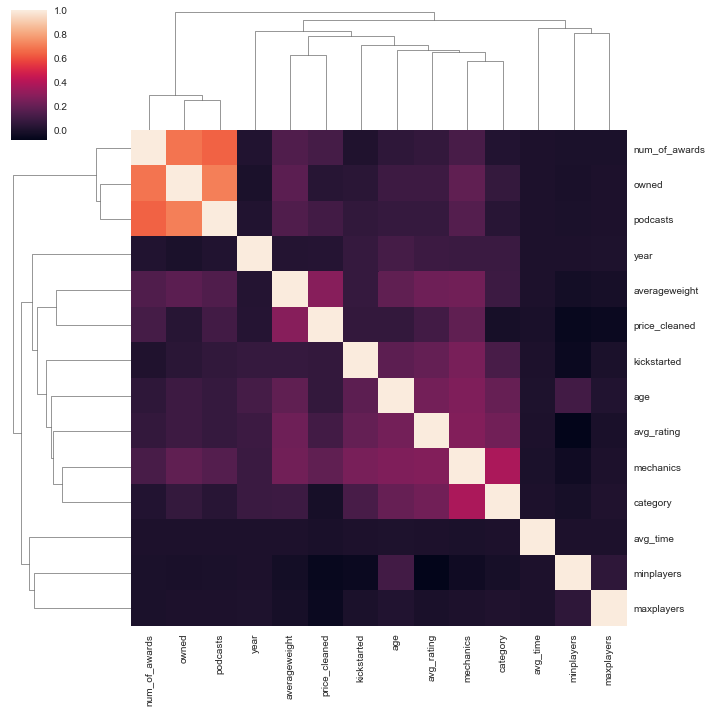

In [391]:
# quick look at correlations 
sns.clustermap(df_smaller.corr())
print(df_smaller.corr())

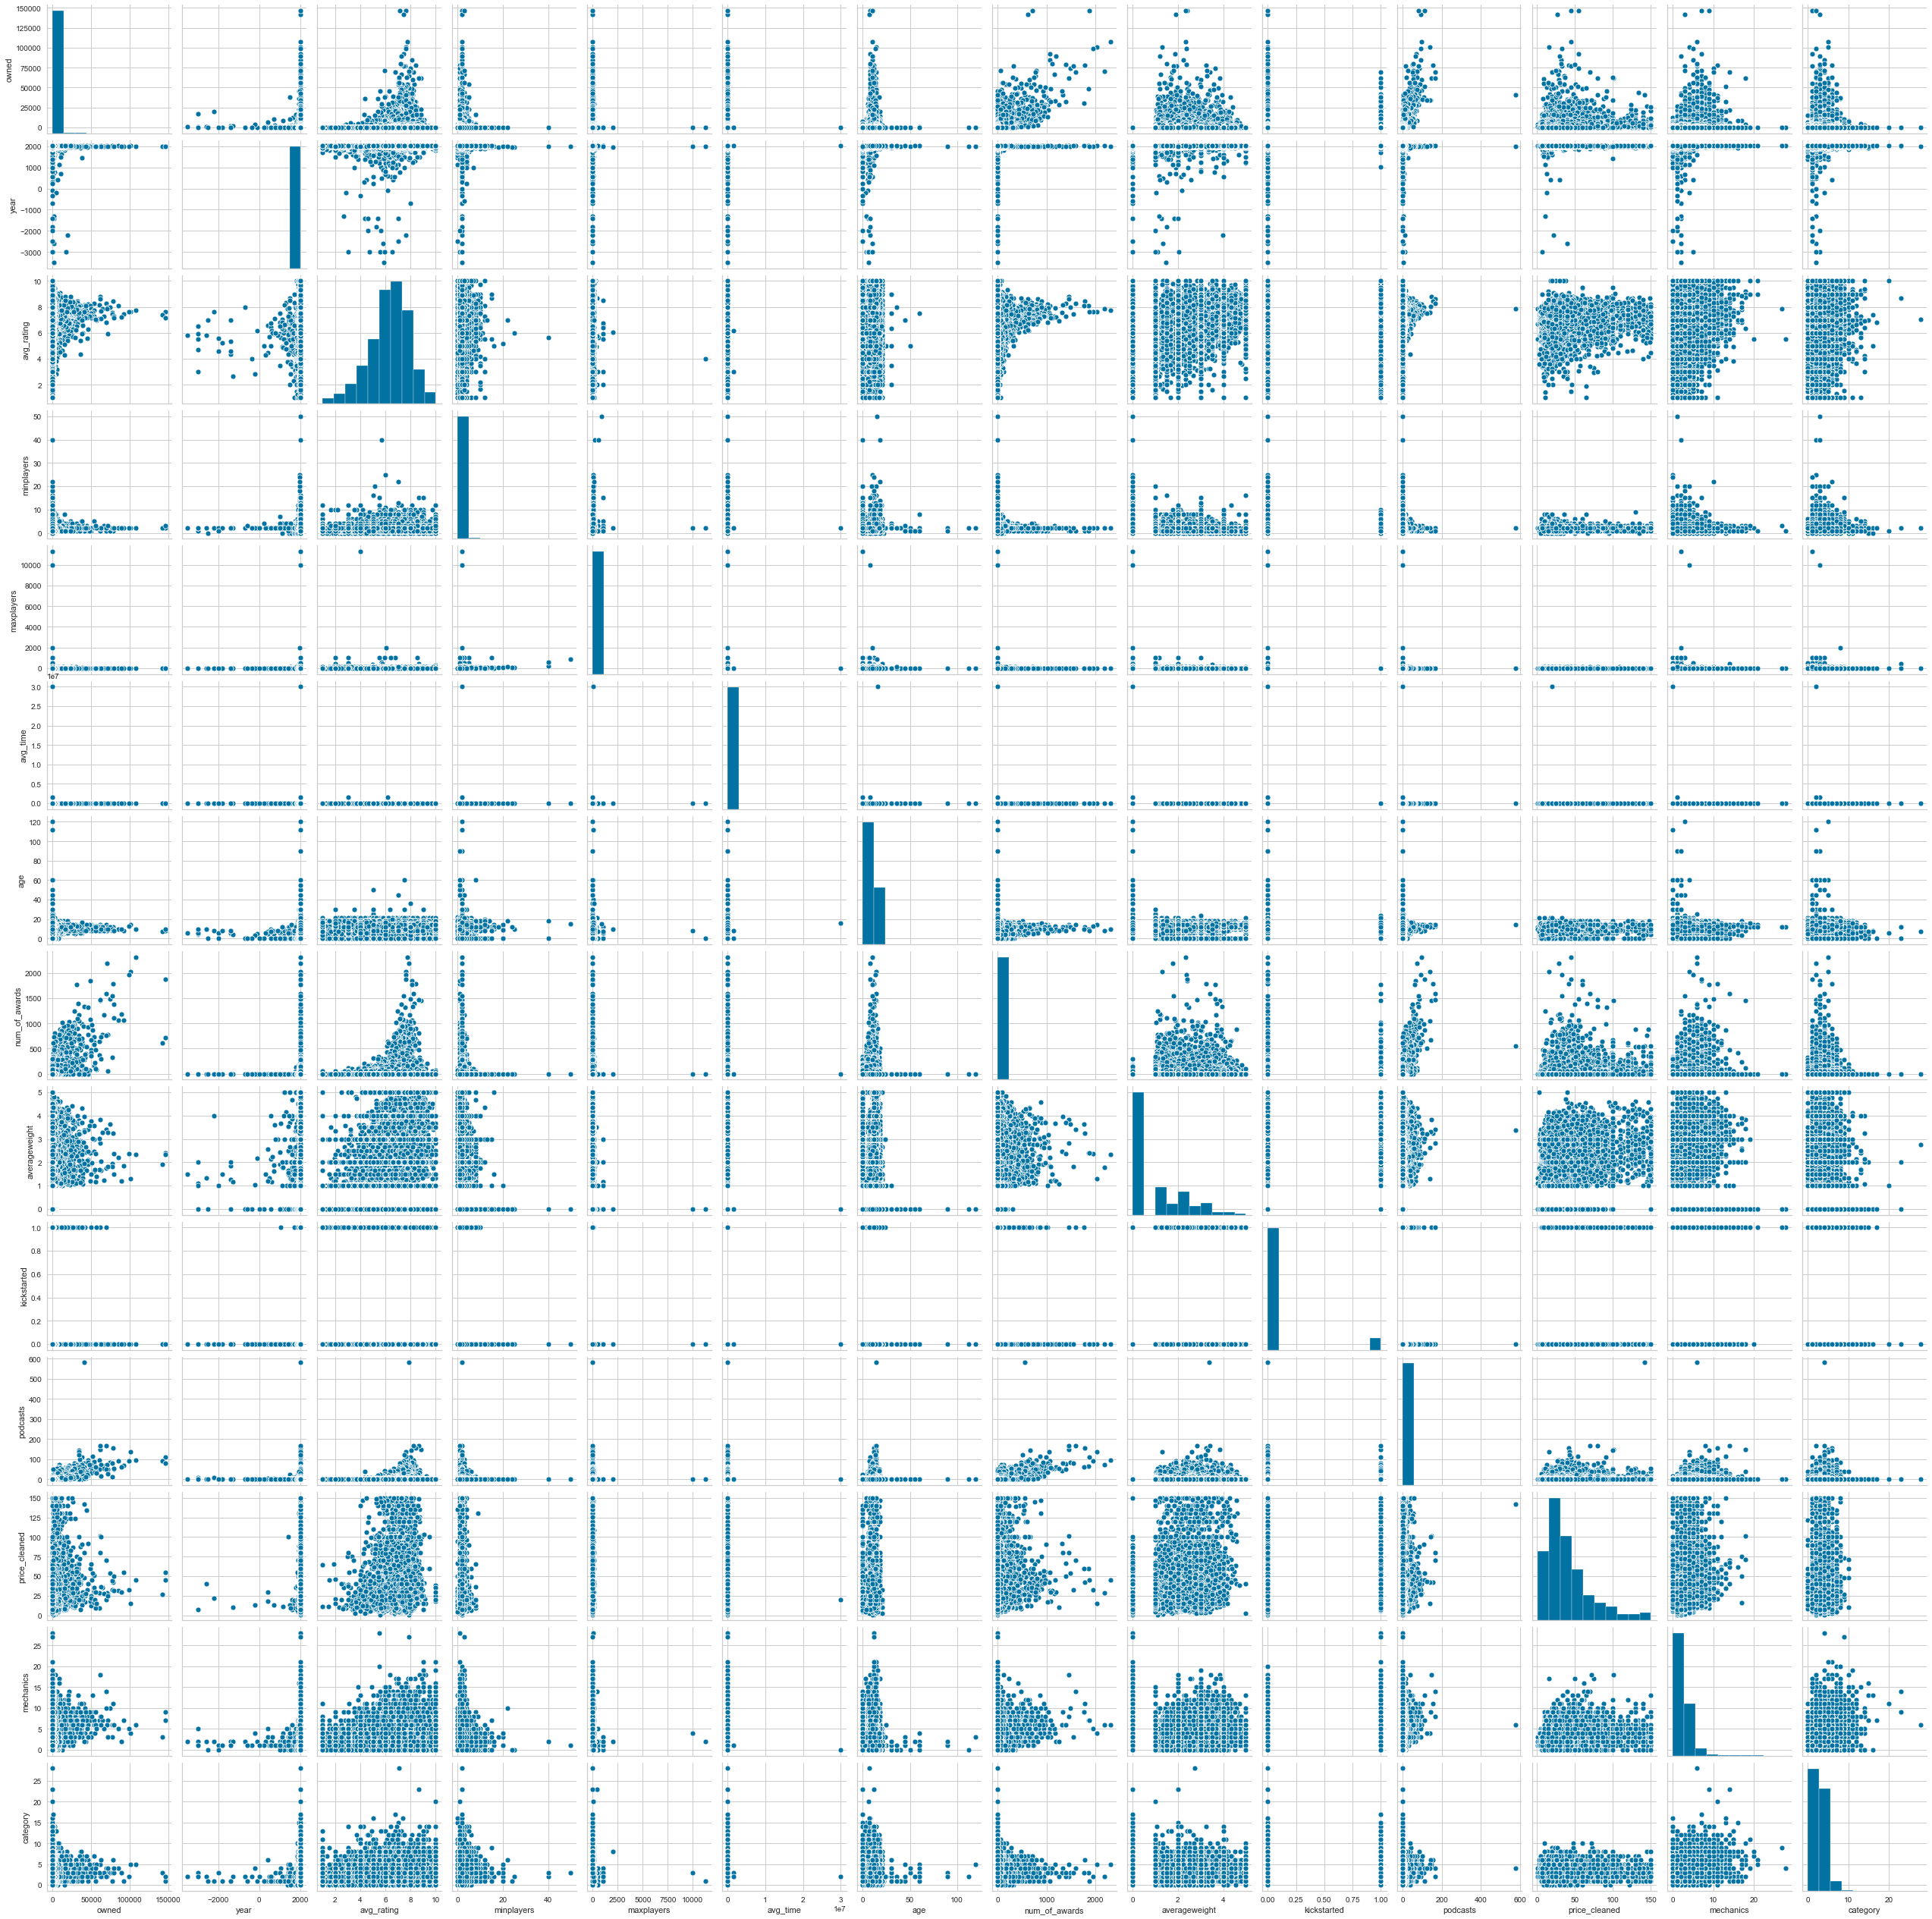

In [392]:
sns.pairplot(df_smaller)

In [393]:
print(df.owned.describe(percentiles=[.25,.5,.75,.8,.9,.95,.97,.99,1]))
df[df.prime == True].owned.describe(percentiles=[.25,.5,.75,.8,.9,.95,.97,.99,1])

count    107164.000000
mean        359.288763
std        2234.738655
min           1.000000
25%           3.000000
50%          16.000000
75%         109.000000
80%         178.000000
90%         547.000000
95%        1314.000000
97%        2265.000000
99%        6230.110000
100%     146531.000000
max      146531.000000
Name: owned, dtype: float64


count      3264.000000
mean       4867.722733
std        9103.261654
min           1.000000
25%         795.750000
50%        2000.000000
75%        4993.250000
80%        6230.200000
90%       10936.800000
95%       19586.600000
97%       26238.400000
99%       45627.990000
100%     141704.000000
max      141704.000000
Name: owned, dtype: float64

In [394]:
df_x = df_smaller

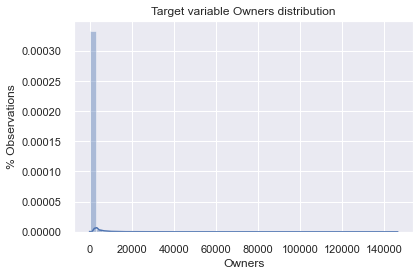

Owners Mean 359.2887630174312
Owners Standard Deviation 2234.738655086638 



In [395]:
fig = plt.figure()
sns.set(color_codes="True")
sns.distplot(df_x['owned'], kde=True);
plt.xlabel('Owners')
plt.ylabel('% Observations')
plt.title('Target variable Owners distribution')
plt.tight_layout()
plt.show();
#fig.savefig('target_mean_rating_hist.png')
y_mean = df_x['owned'].mean()
y_std = df_x['owned'].std()
print('Owners Mean {}'.format(y_mean))
print('Owners Standard Deviation {} \n'.format(y_std))

# Log transform owners

In [396]:
df_smaller['owned'] = df_smaller['owned'] + 0.00001

In [491]:
df_smaller['log_owned']=np.log(df_smaller['owned'])

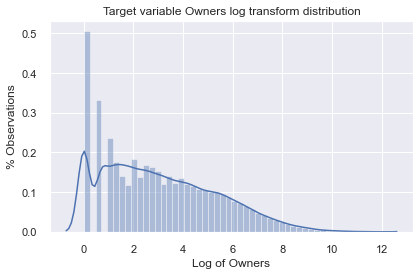

Log of Owners Mean 3.083776793446769
Log of Owners Standard Deviation 2.2695961074294475 



In [492]:
fig = plt.figure()
sns.set(color_codes="True")
sns.distplot(df_smaller['log_owned'], kde=True);
plt.xlabel('Log of Owners')
plt.ylabel('% Observations')
plt.title('Target variable Owners log transform distribution')
plt.tight_layout()
plt.show();
#fig.savefig('target_mean_rating_hist.png')
y_mean = df_smaller['log_owned'].mean()
y_std = df_smaller['log_owned'].std()
print(f'Log of Owners Mean {y_mean}')
print(f'Log of Owners Standard Deviation {y_std} \n')

In [399]:
df_smaller.drop(['owned', 'log_owned'], axis = 1)

,year,avg_rating,minplayers,maxplayers,avg_time,age,num_of_awards,averageweight,kickstarted,podcasts,price_cleaned,mechanics,category
0,2017.0,8.81,1.0,4.0,120.0,14.0,1450,3.8445,1,148,100.88,18,5
1,2015.0,8.62,2.0,4.0,60.0,13.0,1463,2.8318,0,166,79.99,8,2
2,2018.0,8.64,2.0,4.0,120.0,14.0,812,3.9194,1,24,69.54,9,3
3,2016.0,8.43,1.0,5.0,120.0,12.0,1781,3.2363,0,156,41.99,11,6
4,2017.0,8.69,3.0,6.0,480.0,14.0,106,4.2124,0,48,119.95,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120827,2020.0,NaN,1.0,99.0,25.0,10.0,2,0.0000,0,0,NaN,1,1
120828,2020.0,NaN,4.0,12.0,60.0,14.0,2,0.0000,1,0,NaN,0,2
120829,2021.0,NaN,2.0,6.0,60.0,8.0,2,0.0000,0,0,NaN,3,3
120830,2021.0,NaN,1.0,2.0,45.0,12.0,2,0.0000,1,0,NaN,3,4


In [400]:
df_na = df_smaller.dropna()
df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 119980
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   owned          5372 non-null   float64
 1   year           5372 non-null   float64
 2   avg_rating     5372 non-null   float64
 3   minplayers     5372 non-null   float64
 4   maxplayers     5372 non-null   float64
 5   avg_time       5372 non-null   float64
 6   age            5372 non-null   float64
 7   num_of_awards  5372 non-null   int64  
 8   averageweight  5372 non-null   float64
 9   kickstarted    5372 non-null   int64  
 10  podcasts       5372 non-null   int64  
 11  price_cleaned  5372 non-null   float64
 12  mechanics      5372 non-null   int64  
 13  category       5372 non-null   int64  
 14  log_owned      5372 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 671.5 KB


In [459]:
#standardize the features, to get actual interpretable coefficients for each feature
X = StandardScaler().fit_transform(df_na.drop(['owned', 'log_owned'], axis = 1).astype(float))
y = df_na['log_owned']


lr = LinearRegression()
lr.fit(X,y)
#must take absolute value because sklearn makes the errors negative - dont ask me why
mean_squared_errors = np.abs(cross_val_score(lr,X,y,cv=50,scoring='neg_mean_squared_error'))
root_mean_squared_errors = list(map(np.sqrt,mean_squared_errors))
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
metrics.r2_score(y_test, y_pred)

50-fold mean RMSE:  25.870525660775794


-0.26567675520371403

<AxesSubplot:xlabel='owned'>

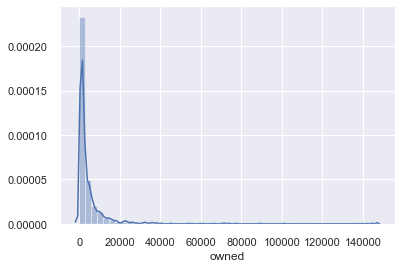

In [427]:
sns.distplot(y_test)

<AxesSubplot:xlabel='rank'>

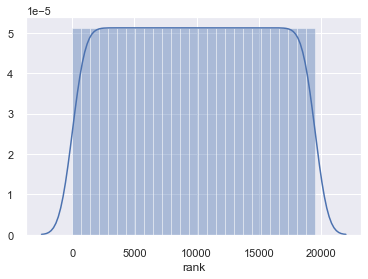

In [428]:
sns.distplot(df['rank'])

<AxesSubplot:>

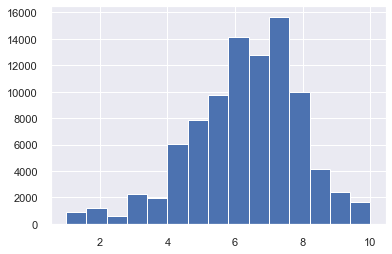

In [429]:
df.avg_rating.hist(bins=15)

<AxesSubplot:xlabel='prime', ylabel='avg_rating'>

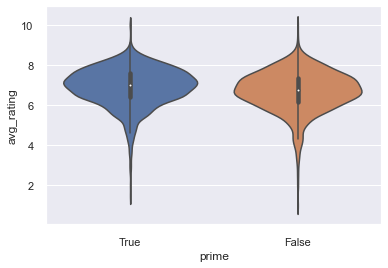

In [430]:
sns.violinplot(x = 'prime', y = 'avg_rating', data = df_small)

<AxesSubplot:xlabel='prime', ylabel='owned'>

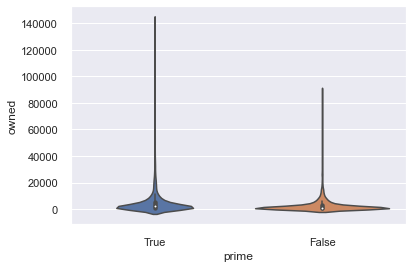

In [431]:
sns.violinplot(x = 'prime', y = 'owned', data = df_small)

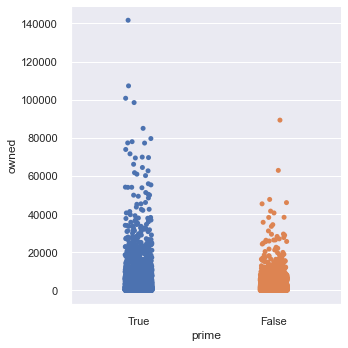

In [432]:
sns.catplot(x = 'prime', y = 'owned', data = df_small)

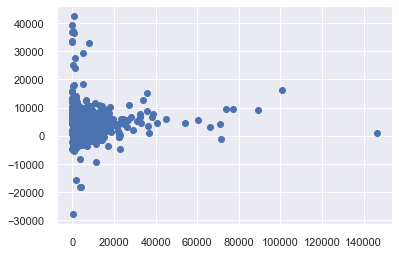

In [433]:
plt.scatter(y_test,y_pred)

In [434]:
lr.fit(X,y)
y_pred = lr.predict(X_test)

In [435]:
df_na.columns

Index(['owned', 'year', 'avg_rating', 'minplayers', 'maxplayers', 'avg_time',
       'age', 'num_of_awards', 'averageweight', 'kickstarted', 'podcasts',
       'price_cleaned', 'mechanics', 'category', 'log_owned'],
      dtype='object')

In [436]:
df.head()

,Unnamed: 0,Unnamed: 0.1,rank,game_id,game_num,names,year,geek_rating,avg_rating,num_votes,...,title,defaultprice,newprice,listprice,url,sponsorurl,body,ggs,price_cleaned,num_of_awards
0,0,0,1.0,/boardgame/174430/gloomhaven,174430,Gloomhaven,2017.0,8.565,8.81,38060.0,...,Get Gloomhaven on Amazon.com $100.88,$100.88,$100.88,$140.00,https://www.amazon.com/dp/B01LZXVN4P?tag=itemt...,https://www.amazon.com/dp/B01LZXVN4P?tag=itemt...,Eligible for Super Saver Shipping!,NaN,100.88,1450
1,1,1,2.0,/boardgame/161936/pandemic-legacy-season-1,161936,Pandemic Legacy: Season 1,2015.0,8.469,8.62,39031.0,...,Get Pandemic Legacy: Season 1 on the Geek Game...,$79.99,$79.99,NaN,https://geekgameshop.com/products/pandemic-leg...,https://geekgameshop.com,NaN,True,79.99,1463
2,2,2,3.0,/boardgame/224517/brass-birmingham,224517,Brass: Birmingham,2018.0,8.322,8.64,15511.0,...,Get Brass: Birmingham on Amazon.com $69.54,$69.54,$69.54,NaN,https://www.amazon.com/dp/1988884047?tag=itemt...,https://www.amazon.com/dp/1988884047?tag=itemt...,Eligible for Super Saver Shipping!,NaN,69.54,812
3,3,3,4.0,/boardgame/167791/terraforming-mars,167791,Terraforming Mars,2016.0,8.284,8.43,58845.0,...,Get Terraforming Mars on Amazon.com $41.99,$41.99,$41.99,$69.95,https://www.amazon.com/dp/B01GSYA4K2?tag=itemt...,https://www.amazon.com/dp/B01GSYA4K2?tag=itemt...,Eligible for Super Saver Shipping!,NaN,41.99,1781
4,4,4,5.0,/boardgame/233078/twilight-imperium-fourth-edi...,233078,Twilight Imperium (Fourth Edition),2017.0,8.224,8.69,11934.0,...,Get Twilight Imperium (Fourth Edition) on Amaz...,$119.95,$119.95,$149.95,https://www.amazon.com/dp/B074YPSTRP?tag=itemt...,https://www.amazon.com/dp/B074YPSTRP?tag=itemt...,Eligible for Super Saver Shipping!,NaN,119.95,106


In [453]:
list(zip(df_na.columns[1:-1], lr.coef_))

[('year', -2.3904607832157807),
 ('avg_rating', 5.27418365369543),
 ('minplayers', 0.761541244820626),
 ('maxplayers', 0.2831716632653265),
 ('avg_time', -2.1680719413579355),
 ('age', -0.4423858138845347),
 ('num_of_awards', 15.764880120915384),
 ('averageweight', 2.4036860129138007),
 ('kickstarted', -2.0070673972936275),
 ('podcasts', 13.054449624875339),
 ('price_cleaned', -1.810912194696477),
 ('mechanics', 5.2961155713352595),
 ('category', 1.7443744875522404)]

In [438]:
X.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [439]:
coeffs = LinearRegression().fit(X,y).coef_
coeff_df = pd.DataFrame(list(zip(df_na.columns[1:-1],np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
coeff_df

,features,betas
6,num_of_awards,15.764880
9,podcasts,13.054450
11,mechanics,5.296116
1,avg_rating,5.274184
7,averageweight,2.403686
0,year,2.390461
4,avg_time,2.168072
8,kickstarted,2.007067
10,price_cleaned,1.810912
12,category,1.744374


# PCA

In [440]:
pca = PCA()
transformed_pca_x = pca.fit_transform(X)
#create component indices
component_names = ["component_"+str(comp) for comp in range(1, len(pca.explained_variance_)+1)]

#generate new component dataframe
transformed_pca_x = pd.DataFrame(transformed_pca_x,columns=component_names)

transformed_pca_x.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13
0,11.490566,9.853816,-0.814115,-0.991301,-0.601004,1.165753,0.540222,-0.965288,0.758237,1.370944,1.231203,-0.135774,0.599807
1,7.955601,11.649655,0.457220,0.334977,0.247738,-0.859474,-0.666487,1.332382,0.202632,1.341633,-1.193732,0.424109,1.805042
2,5.303439,2.539062,-0.057639,-0.549596,-1.105469,0.952867,-0.520565,0.076220,0.508396,-0.795008,-0.104066,-0.134186,-2.523791
3,9.416696,11.850350,-1.011610,-0.247033,1.551540,-1.170653,1.076447,0.593686,1.099932,2.112063,-0.569233,1.113791,-0.256806
4,6.245633,0.014102,-0.463644,3.589238,0.293147,0.453956,-0.093905,-1.641476,1.233478,0.229325,0.875526,-0.289728,1.796054


In [479]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X),y)

In [471]:
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.612445579081485

In [480]:
cv_scores = cross_val_score(lr,X_train,y_train,cv=10)
cv_scores

array([0.58048671, 0.61725702, 0.65619522, 0.62242202, 0.62746519,
       0.52925923, 0.69035127, 0.54070611, 0.61093142, 0.56489828])

In [473]:
np.mean(cv_scores)

0.45444941621443513

In [474]:
df_copy = df_na.copy()

In [476]:
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.29831465997454776

In [481]:
X_test['residuals'] = lr.predict(X_test) - y_test

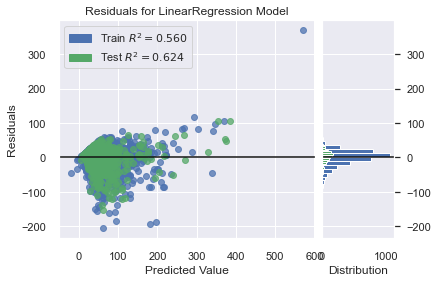

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [465]:
model = LinearRegression()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

In [443]:
df.sort_values('owned').tail(10)

,Unnamed: 0,Unnamed: 0.1,rank,game_id,game_num,names,year,geek_rating,avg_rating,num_votes,...,title,defaultprice,newprice,listprice,url,sponsorurl,body,ggs,price_cleaned,num_of_awards
120817,120817,120817,NaN,/boardgame/320859/sakura-arms-yatsuha-box,320859,Sakura Arms: Yatsuha Box,2021.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120819,120819,120819,NaN,/boardgame/320862/save-patient-zero,320862,Save Patient Zero,2021.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120820,120820,120820,NaN,/boardgameexpansion/320877/qwixx-bonus,320877,Qwixx: Bonus,2020.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120821,120821,120821,NaN,/boardgame/320879/dual-gauge,320879,Dual Gauge,2020.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120823,120823,120823,NaN,/boardgame/320881/aurelian-restorer-world,320881,"Aurelian, Restorer of the World",2020.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120824,120824,120824,NaN,/boardgame/320894/giant-monster-invasion,320894,Giant Monster Invasion!,2014.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120825,120825,120825,NaN,/boardgame/320898/starcraft-tactical-miniature...,320898,Starcraft: Tactical Miniatures Combat,2008.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120827,120827,120827,NaN,/boardgame/320942/blackout,320942,BlackOut,2020.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120828,120828,120828,NaN,/boardgame/320949/trivia-trolls,320949,Trivia Trolls,2020.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
120829,120829,120829,NaN,/boardgame/320950/knight-watch,320950,Knight Watch,2021.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


# model

In [449]:
cv_scores

array([-1.02097125, -0.02615617, -0.14411235, -0.407473  , -0.39112181,
       -1.16811491, -0.83068585,  0.16666339,  0.32398744,  0.10016638])

In [445]:
df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 119980
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   owned          5372 non-null   float64
 1   year           5372 non-null   float64
 2   avg_rating     5372 non-null   float64
 3   minplayers     5372 non-null   float64
 4   maxplayers     5372 non-null   float64
 5   avg_time       5372 non-null   float64
 6   age            5372 non-null   float64
 7   num_of_awards  5372 non-null   int64  
 8   averageweight  5372 non-null   float64
 9   kickstarted    5372 non-null   int64  
 10  podcasts       5372 non-null   int64  
 11  price_cleaned  5372 non-null   float64
 12  mechanics      5372 non-null   int64  
 13  category       5372 non-null   int64  
 14  log_owned      5372 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 671.5 KB


In [458]:
np.mean(cv_scores)

-0.3397818123645059

In [ ]:
metrics.explained_variance_score(lasso.predict(X_test), y_test)

In [418]:
lasso = Lasso(max_iter=10000)#increase the number of iterations for lasso to prevent lack of convergence
lasso.fit(X_train, y_train)
mean_squared_errors_poly3_lasso = np.abs(cross_val_score(lasso,X,y,cv=10))
rmses_lasso_poly3 = list(map(np.sqrt,mean_squared_errors_poly3_lasso))
print("10-fold mean RMSE for degree-3 case, strongest lasso regularization: ",np.mean(rmses_lasso_poly3))

10-fold mean RMSE for degree-3 case, strongest lasso regularization:  0.403925369942076


In [ ]:
metrics.explained_variance_score(lasso.predict(X_test), y_test)

In [ ]:
lasso = Ridge()#increase the number of iterations for lasso to prevent lack of convergence
lasso.fit(X_train, y_train)
mean_squared_errors_poly3_lasso = np.abs(cross_val_score(lasso,X,y,cv=10))
rmses_lasso_poly3 = list(map(np.sqrt,mean_squared_errors_poly3_lasso))
print("10-fold mean RMSE for degree-3 case, strongest lasso regularization: ",np.mean(rmses_lasso_poly3))

In [ ]:
metrics.explained_variance_score(lasso.predict(X_test), y_test)

In [ ]:
lasso.predict(X_test)

In [486]:
#generate features, targets
lr = LinearRegression() #random forest with 50 trees

#train/test split with 10% of data in each split:
for i in range(10):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1)
    lr_fit = lr.fit(X_train,y_train)
    print("Accuracy for split ",i,": ",metrics.accuracy_score(y_test,lr_fit.predict(X_test)))

#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(lr,X_train,y_train,cv=10)

print("10-fold accuracies:\n",cross_val_scores)
print("Std of cv-accuracy:",np.std(cross_val_scores))
print("Mean cv-accuracy:",np.mean(cross_val_scores))

ValueError: continuous is not supported

In [493]:
df_na

,owned,year,avg_rating,minplayers,maxplayers,avg_time,age,num_of_awards,averageweight,kickstarted,podcasts,price_cleaned,mechanics,category,log_owned
0,61713.00001,2017.0,8.81,1.0,4.0,120.0,14.0,1450,3.8445,1,148,100.88,18,5,248.421014
1,61496.00001,2015.0,8.62,2.0,4.0,60.0,13.0,1463,2.8318,0,166,79.99,8,2,247.983870
2,22900.00001,2018.0,8.64,2.0,4.0,120.0,14.0,812,3.9194,1,24,69.54,9,3,151.327460
3,77980.00001,2016.0,8.43,1.0,5.0,120.0,12.0,1781,3.2363,0,156,41.99,11,6,279.248993
4,14924.00001,2017.0,8.69,3.0,6.0,480.0,14.0,106,4.2124,0,48,119.95,12,7,122.163824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118468,105.00001,2020.0,8.59,2.0,4.0,60.0,13.0,2,0.0000,0,0,39.99,4,3,10.246951
118577,56.00001,2020.0,7.83,1.0,5.0,75.0,14.0,2,3.0000,0,0,25.00,4,3,7.483315
118663,12.00001,2020.0,4.75,1.0,4.0,60.0,17.0,2,0.0000,0,0,44.00,2,0,3.464103
119448,12.00001,2020.0,7.25,2.0,5.0,45.0,10.0,2,0.0000,0,0,39.95,2,2,3.464103


In [ ]:
# Single cross-val

X = df_na.drop['owned']
y = all_df_concat['Dice Rolling']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

# CROSS VALIDATION
lr = LinearRegression() 

#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(lr,X_train,y_train,cv=10)

np.mean(cross_val_scores)

# CLEANED

In [530]:
df_smaller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120832 entries, 0 to 120831
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   owned          120832 non-null  int64  
 1   year           111384 non-null  float64
 2   avg_rating     91376 non-null   float64
 3   minplayers     120830 non-null  float64
 4   maxplayers     120830 non-null  float64
 5   avg_time       120830 non-null  float64
 6   age            120830 non-null  float64
 7   num_of_awards  120832 non-null  int64  
 8   averageweight  120832 non-null  float64
 9   kickstarted    120832 non-null  int64  
 10  podcasts       120832 non-null  int64  
 11  price_cleaned  5428 non-null    float64
 12  prime          5543 non-null    object 
 13  title          6999 non-null    object 
 14  defaultprice   6999 non-null    object 
 15  newprice       6999 non-null    object 
 16  listprice      1797 non-null    object 
 17  mechanics      120832 non-nul

In [529]:
df_smaller.to_pickle('df_main.pkl')